<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture06/notebooks/L06_ConvAE_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional autoencoder


Let's create simplest autoencoder for MNIST!

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy,mse

(x_train, y_trainclass), (x_test, y_testclass) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


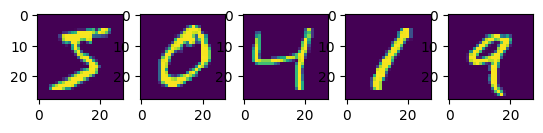

In [ ]:
def plotn(n,x):
  fig,ax = plt.subplots(1,n)
  for i,z in enumerate(x[0:n]):
    ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
  plt.show()

plotn(5,x_train)

In [ ]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img,encoded)

input_rep = Input(shape=(4,4,8))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep,decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 75s 152ms/step - loss: 0.3051 - val_loss: 0.1485
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - loss: 0.1425 - val_loss: 0.1279
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 150ms/step - loss: 0.1266 - val_loss: 0.1188
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 159ms/step - loss: 0.1186 - val_loss: 0.1142
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 166ms/step - loss: 0.1142 - val_loss: 0.1105
Epoch 6/25
 66/469 ━━━━━━━━━━━━━━━━━━━━ 1:06 166ms/step - loss: 0.1100

In [ ]:
y_test = autoencoder.predict(x_test[0:5])
plotn(5,x_test)
plotn(5,y_test)

> **Task 1**: Try to train autoencoder with very small latent vector size, eg. 2, and plot the dots corresponding to different digits. *Hint: Use fully-connected dense layer after the convoluitonal part to reduce the vector size to the required value.*

> **Task 2**: Starting from different digits, obtain their latent space representations, and see what effect adding some noise to the latent space has on the resulting digits.

> **Task 3**: How and why is BCELoss used in the training of autoencoders, particularly when dealing with binary or probabilistic outputs?

> **Task 4**: In the context of a convolutional autoencoder (conv2d AE), how do the downsampling and upsampling procedures work, and why are they important for the reconstruction process?

## Denoising

Autoencoders can be effectively used to remove noise from images. In order to train denoiser, we will start with noise-free images, and add artificial noise to them. Then, we will feed autoencoder with noisy images as input, and noise-free images as output.

Let's see how this works for MNIST:

In [ ]:
def noisify(data):
  return np.clip(data+np.random.normal(loc=0.5,scale=0.5,size=data.shape),0.,1.)

x_train_noise = noisify(x_train)
x_test_noise = noisify(x_test)

plotn(5,x_train_noise)

In [ ]:
autoencoder.fit(x_train_noise, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise, x_test))

In [ ]:
y_test = autoencoder.predict(x_test_noise[0:5])
plotn(5,x_test_noise)
plotn(5,y_test)

> **Exercise:** See how denoiser trained on MNIST digits works for different images. As an example, you can take [Fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset, which has the same image size. Note that denoiser works well only on the same image type that it was trained on (i.e. for the same probability distribution of input data).

## Super-resolution

Similarly to denoiser, we can train autoencoders to increase the resolution of the image. To train super-resolution network, we will start with high-resolution images, and automatically downscale them to produce network inputs. We will then feed autoencoder with small images as inputs and high-res images as outputs.

Let's downscale MNIST to 14x14:

In [ ]:
x_train_lr = tf.keras.layers.AveragePooling2D()(x_train).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D()(x_test).numpy()
plotn(5,x_train_lr)

In [ ]:
input_img = Input(shape=(14, 14, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_img,encoded)

input_rep = Input(shape=(4,4,8))

x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep,decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_lr, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_lr, x_test))

In [ ]:
y_test_lr = autoencoder.predict(x_test_lr[0:5])
plotn(5,x_test_lr)
plotn(5,y_test_lr)

> **Exercise**: Try to train super-resolution network on [CIFAR-10](https://keras.io/api/datasets/cifar10/) for 2x and 4x upscaling. Use noise as input to 4x upscaling model and observe the result.